# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [316]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

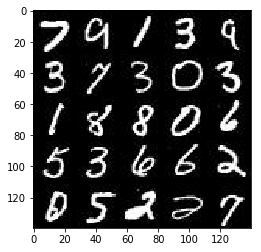

In [317]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

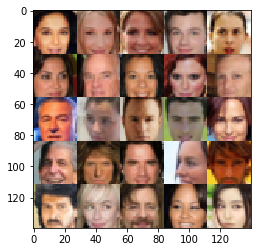

In [318]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [319]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [320]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    input_lr = tf.placeholder(tf.float32, (None), name='input_lr')
    
    return inputs_real, inputs_z, input_lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [321]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha=0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):        

        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)


        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [322]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        
        # Resize
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [323]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # Smoothing 
    smooth = 0.1
    
    # Build the model
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    # g_model is the generator output
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))
    
    return d_loss,  g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [324]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # Get the trainable_variables, split into G and D parts
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):    
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [325]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [326]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps = 0
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    losses = []
    
    print_every = 10
    show_every = 100
    
    input_real, input_z, input_lr = model_inputs(image_width, image_height, image_channels, z_dim) 
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_lr: learning_rate, input_real: batch_images})    
                
                if steps % print_every == 0:
                    # Get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),  
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Difference (should be positive):  {:.4f}...".format(train_loss_d - train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Generator Loss: 11.6103 Discriminator Loss: 0.3540... Difference (should be positive):  -11.2563...
Epoch 1/2... Generator Loss: 11.5069 Discriminator Loss: 0.3632... Difference (should be positive):  -11.1437...
Epoch 1/2... Generator Loss: 15.7333 Discriminator Loss: 0.5572... Difference (should be positive):  -15.1761...
Epoch 1/2... Generator Loss: 6.6171 Discriminator Loss: 0.3826... Difference (should be positive):  -6.2345...
Epoch 1/2... Generator Loss: 7.3404 Discriminator Loss: 0.3342... Difference (should be positive):  -7.0062...
Epoch 1/2... Generator Loss: 6.8678 Discriminator Loss: 0.4033... Difference (should be positive):  -6.4645...
Epoch 1/2... Generator Loss: 6.7803 Discriminator Loss: 0.4580... Difference (should be positive):  -6.3223...
Epoch 1/2... Generator Loss: 7.5008 Discriminator Loss: 0.3352... Difference (should be positive):  -7.1657...
Epoch 1/2... Generator Loss: 9.5299 Discriminator Loss: 0.5246... Difference (should be positive):  -9.005

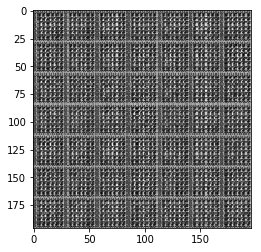

Epoch 1/2... Generator Loss: 8.0923 Discriminator Loss: 0.3311... Difference (should be positive):  -7.7612...
Epoch 1/2... Generator Loss: 6.5392 Discriminator Loss: 0.3293... Difference (should be positive):  -6.2099...
Epoch 1/2... Generator Loss: 6.7086 Discriminator Loss: 0.3372... Difference (should be positive):  -6.3714...
Epoch 1/2... Generator Loss: 7.3889 Discriminator Loss: 0.3320... Difference (should be positive):  -7.0569...
Epoch 1/2... Generator Loss: 7.4072 Discriminator Loss: 0.3337... Difference (should be positive):  -7.0735...
Epoch 1/2... Generator Loss: 7.7528 Discriminator Loss: 0.3295... Difference (should be positive):  -7.4232...
Epoch 1/2... Generator Loss: 6.8723 Discriminator Loss: 0.3332... Difference (should be positive):  -6.5391...
Epoch 1/2... Generator Loss: 1.1523 Discriminator Loss: 1.8462... Difference (should be positive):  0.6939...
Epoch 1/2... Generator Loss: 10.1554 Discriminator Loss: 2.6810... Difference (should be positive):  -7.4744...
E

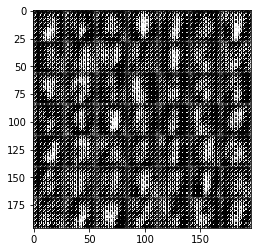

Epoch 1/2... Generator Loss: 3.4594 Discriminator Loss: 0.4223... Difference (should be positive):  -3.0371...
Epoch 1/2... Generator Loss: 0.5763 Discriminator Loss: 1.7628... Difference (should be positive):  1.1865...
Epoch 1/2... Generator Loss: 2.9253 Discriminator Loss: 0.5169... Difference (should be positive):  -2.4084...
Epoch 1/2... Generator Loss: 2.8303 Discriminator Loss: 0.5008... Difference (should be positive):  -2.3295...
Epoch 1/2... Generator Loss: 1.1363 Discriminator Loss: 0.9172... Difference (should be positive):  -0.2191...
Epoch 1/2... Generator Loss: 2.1009 Discriminator Loss: 0.5493... Difference (should be positive):  -1.5517...
Epoch 1/2... Generator Loss: 2.9760 Discriminator Loss: 0.4551... Difference (should be positive):  -2.5210...
Epoch 1/2... Generator Loss: 1.2690 Discriminator Loss: 0.9074... Difference (should be positive):  -0.3616...
Epoch 1/2... Generator Loss: 3.5624 Discriminator Loss: 0.3852... Difference (should be positive):  -3.1772...
Ep

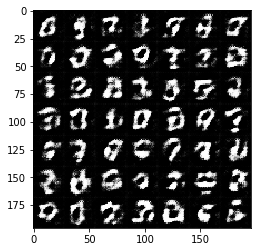

Epoch 1/2... Generator Loss: 2.6909 Discriminator Loss: 0.4349... Difference (should be positive):  -2.2560...
Epoch 1/2... Generator Loss: 3.2666 Discriminator Loss: 0.9556... Difference (should be positive):  -2.3110...
Epoch 1/2... Generator Loss: 3.1225 Discriminator Loss: 0.4385... Difference (should be positive):  -2.6840...
Epoch 1/2... Generator Loss: 3.8275 Discriminator Loss: 0.3656... Difference (should be positive):  -3.4619...
Epoch 1/2... Generator Loss: 3.7181 Discriminator Loss: 0.3689... Difference (should be positive):  -3.3492...
Epoch 1/2... Generator Loss: 4.2688 Discriminator Loss: 0.3501... Difference (should be positive):  -3.9187...
Epoch 1/2... Generator Loss: 3.9573 Discriminator Loss: 0.3590... Difference (should be positive):  -3.5983...
Epoch 1/2... Generator Loss: 3.3953 Discriminator Loss: 0.4910... Difference (should be positive):  -2.9043...
Epoch 1/2... Generator Loss: 3.2357 Discriminator Loss: 0.4079... Difference (should be positive):  -2.8278...
E

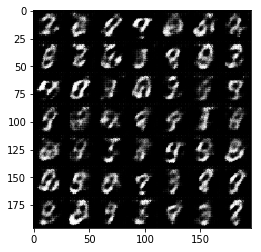

Epoch 1/2... Generator Loss: 4.0870 Discriminator Loss: 0.3548... Difference (should be positive):  -3.7322...
Epoch 1/2... Generator Loss: 4.4776 Discriminator Loss: 0.3533... Difference (should be positive):  -4.1242...
Epoch 1/2... Generator Loss: 3.8857 Discriminator Loss: 0.3617... Difference (should be positive):  -3.5240...
Epoch 1/2... Generator Loss: 5.6225 Discriminator Loss: 0.4789... Difference (should be positive):  -5.1436...
Epoch 1/2... Generator Loss: 2.3959 Discriminator Loss: 0.5244... Difference (should be positive):  -1.8715...
Epoch 1/2... Generator Loss: 5.1290 Discriminator Loss: 0.4202... Difference (should be positive):  -4.7088...
Epoch 1/2... Generator Loss: 0.1342 Discriminator Loss: 2.6172... Difference (should be positive):  2.4830...
Epoch 1/2... Generator Loss: 1.0672 Discriminator Loss: 0.9048... Difference (should be positive):  -0.1624...
Epoch 1/2... Generator Loss: 2.3677 Discriminator Loss: 0.4630... Difference (should be positive):  -1.9048...
Ep

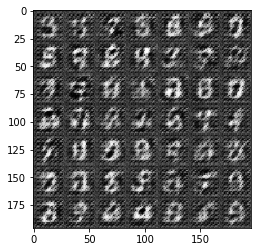

Epoch 1/2... Generator Loss: 7.8212 Discriminator Loss: 0.6428... Difference (should be positive):  -7.1784...
Epoch 1/2... Generator Loss: 7.0797 Discriminator Loss: 0.3408... Difference (should be positive):  -6.7389...
Epoch 1/2... Generator Loss: 2.1423 Discriminator Loss: 0.5449... Difference (should be positive):  -1.5973...
Epoch 1/2... Generator Loss: 8.9122 Discriminator Loss: 1.7093... Difference (should be positive):  -7.2029...
Epoch 1/2... Generator Loss: 5.1269 Discriminator Loss: 0.3609... Difference (should be positive):  -4.7661...
Epoch 1/2... Generator Loss: 7.7949 Discriminator Loss: 0.3839... Difference (should be positive):  -7.4110...
Epoch 1/2... Generator Loss: 2.8277 Discriminator Loss: 0.4113... Difference (should be positive):  -2.4164...
Epoch 1/2... Generator Loss: 0.1585 Discriminator Loss: 2.8858... Difference (should be positive):  2.7273...
Epoch 1/2... Generator Loss: 2.1378 Discriminator Loss: 0.5650... Difference (should be positive):  -1.5727...
Ep

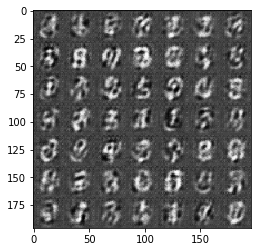

Epoch 1/2... Generator Loss: 2.4422 Discriminator Loss: 0.4897... Difference (should be positive):  -1.9524...
Epoch 1/2... Generator Loss: 8.5881 Discriminator Loss: 1.2498... Difference (should be positive):  -7.3383...
Epoch 1/2... Generator Loss: 2.3297 Discriminator Loss: 0.5034... Difference (should be positive):  -1.8263...
Epoch 1/2... Generator Loss: 3.8667 Discriminator Loss: 0.3800... Difference (should be positive):  -3.4867...
Epoch 1/2... Generator Loss: 4.3884 Discriminator Loss: 0.3628... Difference (should be positive):  -4.0256...
Epoch 1/2... Generator Loss: 6.0133 Discriminator Loss: 0.4040... Difference (should be positive):  -5.6093...
Epoch 1/2... Generator Loss: 1.6565 Discriminator Loss: 0.6012... Difference (should be positive):  -1.0553...
Epoch 1/2... Generator Loss: 13.1632 Discriminator Loss: 0.3805... Difference (should be positive):  -12.7827...
Epoch 1/2... Generator Loss: 2.8627 Discriminator Loss: 0.5141... Difference (should be positive):  -2.3486...

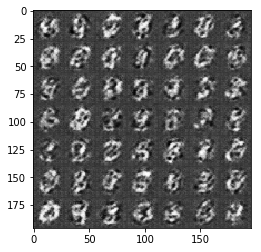

Epoch 1/2... Generator Loss: 6.1121 Discriminator Loss: 0.3453... Difference (should be positive):  -5.7667...
Epoch 1/2... Generator Loss: 1.3108 Discriminator Loss: 0.7437... Difference (should be positive):  -0.5671...
Epoch 1/2... Generator Loss: 1.9877 Discriminator Loss: 0.6317... Difference (should be positive):  -1.3560...
Epoch 1/2... Generator Loss: 2.7242 Discriminator Loss: 0.4496... Difference (should be positive):  -2.2746...
Epoch 1/2... Generator Loss: 4.8757 Discriminator Loss: 0.4298... Difference (should be positive):  -4.4459...
Epoch 1/2... Generator Loss: 4.0294 Discriminator Loss: 0.3856... Difference (should be positive):  -3.6438...
Epoch 1/2... Generator Loss: 6.7739 Discriminator Loss: 0.4208... Difference (should be positive):  -6.3531...
Epoch 1/2... Generator Loss: 1.6064 Discriminator Loss: 0.6369... Difference (should be positive):  -0.9695...
Epoch 1/2... Generator Loss: 1.7234 Discriminator Loss: 0.6570... Difference (should be positive):  -1.0664...
E

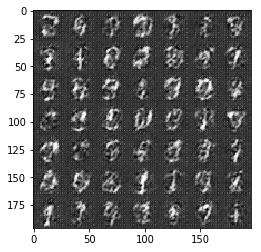

Epoch 1/2... Generator Loss: 7.2459 Discriminator Loss: 0.3716... Difference (should be positive):  -6.8744...
Epoch 1/2... Generator Loss: 6.8974 Discriminator Loss: 0.3420... Difference (should be positive):  -6.5554...
Epoch 1/2... Generator Loss: 4.5304 Discriminator Loss: 0.6653... Difference (should be positive):  -3.8651...
Epoch 1/2... Generator Loss: 4.7254 Discriminator Loss: 0.3602... Difference (should be positive):  -4.3652...
Epoch 1/2... Generator Loss: 5.7097 Discriminator Loss: 0.3623... Difference (should be positive):  -5.3475...
Epoch 1/2... Generator Loss: 5.4018 Discriminator Loss: 0.3468... Difference (should be positive):  -5.0550...
Epoch 1/2... Generator Loss: 2.7301 Discriminator Loss: 0.4315... Difference (should be positive):  -2.2986...
Epoch 1/2... Generator Loss: 11.9969 Discriminator Loss: 0.7248... Difference (should be positive):  -11.2721...
Epoch 1/2... Generator Loss: 6.3962 Discriminator Loss: 0.3439... Difference (should be positive):  -6.0524...

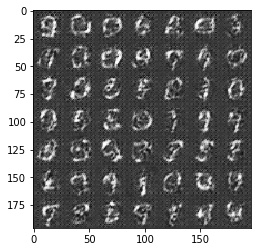

Epoch 1/2... Generator Loss: 5.5638 Discriminator Loss: 0.8057... Difference (should be positive):  -4.7581...
Epoch 1/2... Generator Loss: 1.5765 Discriminator Loss: 0.6316... Difference (should be positive):  -0.9449...
Epoch 1/2... Generator Loss: 4.2202 Discriminator Loss: 0.3778... Difference (should be positive):  -3.8424...
Epoch 2/2... Generator Loss: 1.7796 Discriminator Loss: 0.6016... Difference (should be positive):  -1.1780...
Epoch 2/2... Generator Loss: 4.6619 Discriminator Loss: 0.3531... Difference (should be positive):  -4.3088...
Epoch 2/2... Generator Loss: 2.9772 Discriminator Loss: 0.4289... Difference (should be positive):  -2.5483...
Epoch 2/2... Generator Loss: 2.7816 Discriminator Loss: 0.4195... Difference (should be positive):  -2.3621...
Epoch 2/2... Generator Loss: 6.2044 Discriminator Loss: 0.3365... Difference (should be positive):  -5.8679...
Epoch 2/2... Generator Loss: 3.1913 Discriminator Loss: 0.3984... Difference (should be positive):  -2.7930...
E

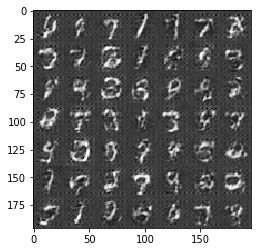

Epoch 2/2... Generator Loss: 3.5121 Discriminator Loss: 0.3657... Difference (should be positive):  -3.1464...
Epoch 2/2... Generator Loss: 3.4899 Discriminator Loss: 0.3751... Difference (should be positive):  -3.1149...
Epoch 2/2... Generator Loss: 4.3476 Discriminator Loss: 1.5387... Difference (should be positive):  -2.8089...
Epoch 2/2... Generator Loss: 1.3595 Discriminator Loss: 0.8848... Difference (should be positive):  -0.4747...
Epoch 2/2... Generator Loss: 1.5537 Discriminator Loss: 0.6704... Difference (should be positive):  -0.8833...
Epoch 2/2... Generator Loss: 2.1110 Discriminator Loss: 0.6469... Difference (should be positive):  -1.4641...
Epoch 2/2... Generator Loss: 2.0980 Discriminator Loss: 0.5694... Difference (should be positive):  -1.5286...
Epoch 2/2... Generator Loss: 1.8028 Discriminator Loss: 0.5531... Difference (should be positive):  -1.2497...
Epoch 2/2... Generator Loss: 1.6362 Discriminator Loss: 0.6040... Difference (should be positive):  -1.0322...
E

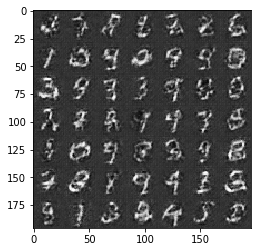

Epoch 2/2... Generator Loss: 1.8975 Discriminator Loss: 0.5586... Difference (should be positive):  -1.3390...
Epoch 2/2... Generator Loss: 1.4006 Discriminator Loss: 0.6768... Difference (should be positive):  -0.7239...
Epoch 2/2... Generator Loss: 1.9728 Discriminator Loss: 0.5186... Difference (should be positive):  -1.4541...
Epoch 2/2... Generator Loss: 4.4001 Discriminator Loss: 0.3824... Difference (should be positive):  -4.0177...
Epoch 2/2... Generator Loss: 2.0763 Discriminator Loss: 0.5077... Difference (should be positive):  -1.5685...
Epoch 2/2... Generator Loss: 3.1558 Discriminator Loss: 0.3900... Difference (should be positive):  -2.7658...
Epoch 2/2... Generator Loss: 2.4901 Discriminator Loss: 0.4659... Difference (should be positive):  -2.0243...
Epoch 2/2... Generator Loss: 4.7309 Discriminator Loss: 0.5580... Difference (should be positive):  -4.1729...
Epoch 2/2... Generator Loss: 3.2637 Discriminator Loss: 1.8231... Difference (should be positive):  -1.4405...
E

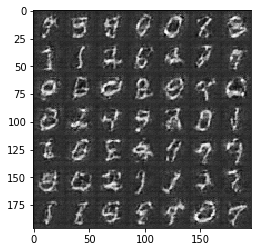

Epoch 2/2... Generator Loss: 2.1969 Discriminator Loss: 0.5928... Difference (should be positive):  -1.6041...
Epoch 2/2... Generator Loss: 1.1232 Discriminator Loss: 0.8100... Difference (should be positive):  -0.3132...
Epoch 2/2... Generator Loss: 2.4785 Discriminator Loss: 0.4567... Difference (should be positive):  -2.0218...
Epoch 2/2... Generator Loss: 3.3578 Discriminator Loss: 0.3735... Difference (should be positive):  -2.9843...
Epoch 2/2... Generator Loss: 3.7247 Discriminator Loss: 0.3789... Difference (should be positive):  -3.3459...
Epoch 2/2... Generator Loss: 4.8425 Discriminator Loss: 0.3575... Difference (should be positive):  -4.4851...
Epoch 2/2... Generator Loss: 3.8766 Discriminator Loss: 0.3557... Difference (should be positive):  -3.5209...
Epoch 2/2... Generator Loss: 4.5091 Discriminator Loss: 0.4050... Difference (should be positive):  -4.1041...
Epoch 2/2... Generator Loss: 2.4541 Discriminator Loss: 0.4616... Difference (should be positive):  -1.9925...
E

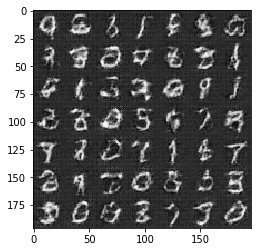

Epoch 2/2... Generator Loss: 2.4310 Discriminator Loss: 0.4589... Difference (should be positive):  -1.9721...
Epoch 2/2... Generator Loss: 3.6846 Discriminator Loss: 0.3640... Difference (should be positive):  -3.3207...
Epoch 2/2... Generator Loss: 2.7191 Discriminator Loss: 0.4243... Difference (should be positive):  -2.2948...
Epoch 2/2... Generator Loss: 0.6692 Discriminator Loss: 1.1934... Difference (should be positive):  0.5241...
Epoch 2/2... Generator Loss: 2.0467 Discriminator Loss: 0.7320... Difference (should be positive):  -1.3147...
Epoch 2/2... Generator Loss: 1.6865 Discriminator Loss: 0.6096... Difference (should be positive):  -1.0769...
Epoch 2/2... Generator Loss: 2.3215 Discriminator Loss: 0.5275... Difference (should be positive):  -1.7940...
Epoch 2/2... Generator Loss: 1.7917 Discriminator Loss: 0.5641... Difference (should be positive):  -1.2276...
Epoch 2/2... Generator Loss: 2.3339 Discriminator Loss: 0.4786... Difference (should be positive):  -1.8554...
Ep

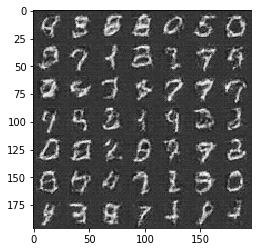

Epoch 2/2... Generator Loss: 4.9561 Discriminator Loss: 0.3770... Difference (should be positive):  -4.5790...
Epoch 2/2... Generator Loss: 3.1939 Discriminator Loss: 0.3845... Difference (should be positive):  -2.8095...
Epoch 2/2... Generator Loss: 6.6804 Discriminator Loss: 0.3359... Difference (should be positive):  -6.3445...
Epoch 2/2... Generator Loss: 3.1756 Discriminator Loss: 0.3896... Difference (should be positive):  -2.7860...
Epoch 2/2... Generator Loss: 4.5526 Discriminator Loss: 0.3916... Difference (should be positive):  -4.1610...
Epoch 2/2... Generator Loss: 2.9779 Discriminator Loss: 0.4287... Difference (should be positive):  -2.5492...
Epoch 2/2... Generator Loss: 0.0647 Discriminator Loss: 5.6579... Difference (should be positive):  5.5932...
Epoch 2/2... Generator Loss: 1.4137 Discriminator Loss: 0.7047... Difference (should be positive):  -0.7089...
Epoch 2/2... Generator Loss: 1.5088 Discriminator Loss: 0.6391... Difference (should be positive):  -0.8697...
Ep

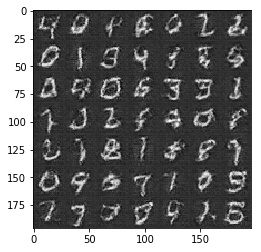

Epoch 2/2... Generator Loss: 0.1665 Discriminator Loss: 2.4341... Difference (should be positive):  2.2676...
Epoch 2/2... Generator Loss: 1.9842 Discriminator Loss: 0.6151... Difference (should be positive):  -1.3691...
Epoch 2/2... Generator Loss: 1.6489 Discriminator Loss: 0.5943... Difference (should be positive):  -1.0546...
Epoch 2/2... Generator Loss: 2.9265 Discriminator Loss: 0.6566... Difference (should be positive):  -2.2699...
Epoch 2/2... Generator Loss: 1.8573 Discriminator Loss: 0.5415... Difference (should be positive):  -1.3158...
Epoch 2/2... Generator Loss: 3.1458 Discriminator Loss: 0.4023... Difference (should be positive):  -2.7436...
Epoch 2/2... Generator Loss: 2.6776 Discriminator Loss: 0.4288... Difference (should be positive):  -2.2488...
Epoch 2/2... Generator Loss: 2.2695 Discriminator Loss: 0.4540... Difference (should be positive):  -1.8155...
Epoch 2/2... Generator Loss: 2.6364 Discriminator Loss: 0.4275... Difference (should be positive):  -2.2088...
Ep

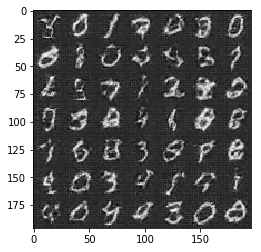

Epoch 2/2... Generator Loss: 3.1589 Discriminator Loss: 0.4018... Difference (should be positive):  -2.7571...
Epoch 2/2... Generator Loss: 3.1090 Discriminator Loss: 0.3979... Difference (should be positive):  -2.7112...
Epoch 2/2... Generator Loss: 5.1247 Discriminator Loss: 0.3428... Difference (should be positive):  -4.7819...
Epoch 2/2... Generator Loss: 3.6009 Discriminator Loss: 0.3742... Difference (should be positive):  -3.2266...
Epoch 2/2... Generator Loss: 2.4103 Discriminator Loss: 0.4405... Difference (should be positive):  -1.9699...
Epoch 2/2... Generator Loss: 3.5395 Discriminator Loss: 0.3648... Difference (should be positive):  -3.1747...
Epoch 2/2... Generator Loss: 6.9350 Discriminator Loss: 0.3373... Difference (should be positive):  -6.5976...
Epoch 2/2... Generator Loss: 4.3115 Discriminator Loss: 0.3638... Difference (should be positive):  -3.9477...
Epoch 2/2... Generator Loss: 2.7608 Discriminator Loss: 0.4054... Difference (should be positive):  -2.3555...
E

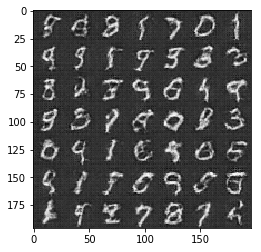

Epoch 2/2... Generator Loss: 0.8324 Discriminator Loss: 1.1107... Difference (should be positive):  0.2783...
Epoch 2/2... Generator Loss: 1.0033 Discriminator Loss: 0.9979... Difference (should be positive):  -0.0054...
Epoch 2/2... Generator Loss: 2.0604 Discriminator Loss: 0.7759... Difference (should be positive):  -1.2845...
Epoch 2/2... Generator Loss: 1.5090 Discriminator Loss: 0.7928... Difference (should be positive):  -0.7162...
Epoch 2/2... Generator Loss: 0.8795 Discriminator Loss: 1.0048... Difference (should be positive):  0.1253...
Epoch 2/2... Generator Loss: 2.3143 Discriminator Loss: 0.7129... Difference (should be positive):  -1.6014...
Epoch 2/2... Generator Loss: 2.3389 Discriminator Loss: 0.5910... Difference (should be positive):  -1.7479...
Epoch 2/2... Generator Loss: 0.7586 Discriminator Loss: 1.1120... Difference (should be positive):  0.3533...
Epoch 2/2... Generator Loss: 1.2349 Discriminator Loss: 0.8007... Difference (should be positive):  -0.4341...
Epoc

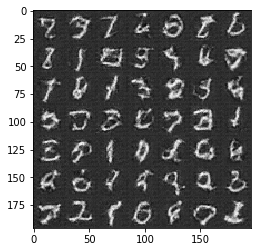

Epoch 2/2... Generator Loss: 2.6512 Discriminator Loss: 0.8035... Difference (should be positive):  -1.8477...
Epoch 2/2... Generator Loss: 1.1810 Discriminator Loss: 0.7676... Difference (should be positive):  -0.4134...
Epoch 2/2... Generator Loss: 1.5101 Discriminator Loss: 0.6443... Difference (should be positive):  -0.8658...
Epoch 2/2... Generator Loss: 1.8006 Discriminator Loss: 0.5517... Difference (should be positive):  -1.2489...
Epoch 2/2... Generator Loss: 4.1511 Discriminator Loss: 0.4982... Difference (should be positive):  -3.6529...
Epoch 2/2... Generator Loss: 4.3889 Discriminator Loss: 0.4764... Difference (should be positive):  -3.9126...
Epoch 2/2... Generator Loss: 4.4064 Discriminator Loss: 0.3541... Difference (should be positive):  -4.0523...


In [328]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Generator Loss: 4.9198 Discriminator Loss: 0.4466... Difference (should be positive):  -4.4732...
Epoch 1/1... Generator Loss: 7.3413 Discriminator Loss: 0.4996... Difference (should be positive):  -6.8416...
Epoch 1/1... Generator Loss: 12.9425 Discriminator Loss: 0.4271... Difference (should be positive):  -12.5153...
Epoch 1/1... Generator Loss: 0.5925 Discriminator Loss: 2.6731... Difference (should be positive):  2.0805...
Epoch 1/1... Generator Loss: 0.6952 Discriminator Loss: 1.5880... Difference (should be positive):  0.8928...
Epoch 1/1... Generator Loss: 6.4010 Discriminator Loss: 1.0484... Difference (should be positive):  -5.3526...
Epoch 1/1... Generator Loss: 2.4439 Discriminator Loss: 0.5561... Difference (should be positive):  -1.8878...
Epoch 1/1... Generator Loss: 2.7333 Discriminator Loss: 0.4710... Difference (should be positive):  -2.2623...
Epoch 1/1... Generator Loss: 2.7430 Discriminator Loss: 0.4562... Difference (should be positive):  -2.2868...
E

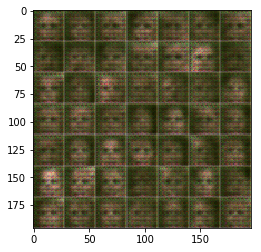

Epoch 1/1... Generator Loss: 4.4504 Discriminator Loss: 0.4000... Difference (should be positive):  -4.0504...
Epoch 1/1... Generator Loss: 4.7893 Discriminator Loss: 0.3542... Difference (should be positive):  -4.4351...
Epoch 1/1... Generator Loss: 4.1088 Discriminator Loss: 0.3742... Difference (should be positive):  -3.7347...
Epoch 1/1... Generator Loss: 5.1043 Discriminator Loss: 0.3511... Difference (should be positive):  -4.7533...
Epoch 1/1... Generator Loss: 9.5539 Discriminator Loss: 0.7291... Difference (should be positive):  -8.8248...
Epoch 1/1... Generator Loss: 7.4510 Discriminator Loss: 0.7473... Difference (should be positive):  -6.7037...
Epoch 1/1... Generator Loss: 10.5233 Discriminator Loss: 0.7998... Difference (should be positive):  -9.7235...
Epoch 1/1... Generator Loss: 7.0647 Discriminator Loss: 0.3839... Difference (should be positive):  -6.6808...
Epoch 1/1... Generator Loss: 5.0186 Discriminator Loss: 0.5014... Difference (should be positive):  -4.5173...


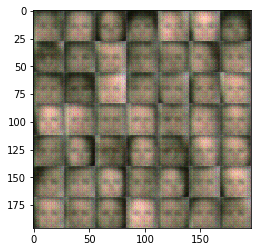

Epoch 1/1... Generator Loss: 3.1218 Discriminator Loss: 0.3858... Difference (should be positive):  -2.7360...
Epoch 1/1... Generator Loss: 3.6580 Discriminator Loss: 0.3686... Difference (should be positive):  -3.2894...
Epoch 1/1... Generator Loss: 5.3220 Discriminator Loss: 0.3586... Difference (should be positive):  -4.9635...
Epoch 1/1... Generator Loss: 0.9540 Discriminator Loss: 1.6295... Difference (should be positive):  0.6755...
Epoch 1/1... Generator Loss: 1.5343 Discriminator Loss: 0.7633... Difference (should be positive):  -0.7710...
Epoch 1/1... Generator Loss: 0.8330 Discriminator Loss: 1.5275... Difference (should be positive):  0.6945...
Epoch 1/1... Generator Loss: 0.7403 Discriminator Loss: 1.4461... Difference (should be positive):  0.7058...
Epoch 1/1... Generator Loss: 0.7924 Discriminator Loss: 1.1663... Difference (should be positive):  0.3739...
Epoch 1/1... Generator Loss: 1.1563 Discriminator Loss: 1.2950... Difference (should be positive):  0.1387...
Epoch 

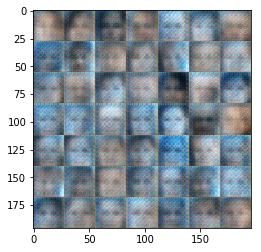

Epoch 1/1... Generator Loss: 1.6809 Discriminator Loss: 0.8081... Difference (should be positive):  -0.8729...
Epoch 1/1... Generator Loss: 4.2003 Discriminator Loss: 0.3838... Difference (should be positive):  -3.8164...
Epoch 1/1... Generator Loss: 5.0321 Discriminator Loss: 0.4863... Difference (should be positive):  -4.5458...
Epoch 1/1... Generator Loss: 1.3383 Discriminator Loss: 0.8146... Difference (should be positive):  -0.5236...
Epoch 1/1... Generator Loss: 5.9804 Discriminator Loss: 1.7045... Difference (should be positive):  -4.2759...
Epoch 1/1... Generator Loss: 4.1148 Discriminator Loss: 0.5352... Difference (should be positive):  -3.5795...
Epoch 1/1... Generator Loss: 7.3743 Discriminator Loss: 0.4545... Difference (should be positive):  -6.9198...
Epoch 1/1... Generator Loss: 0.6142 Discriminator Loss: 1.3275... Difference (should be positive):  0.7133...
Epoch 1/1... Generator Loss: 3.8060 Discriminator Loss: 0.3900... Difference (should be positive):  -3.4160...
Ep

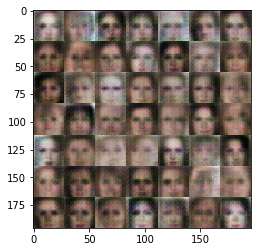

Epoch 1/1... Generator Loss: 13.1380 Discriminator Loss: 0.6780... Difference (should be positive):  -12.4600...
Epoch 1/1... Generator Loss: 1.9763 Discriminator Loss: 0.5268... Difference (should be positive):  -1.4496...
Epoch 1/1... Generator Loss: 1.2905 Discriminator Loss: 0.7915... Difference (should be positive):  -0.4990...
Epoch 1/1... Generator Loss: 9.9811 Discriminator Loss: 0.3492... Difference (should be positive):  -9.6319...
Epoch 1/1... Generator Loss: 7.1833 Discriminator Loss: 0.3571... Difference (should be positive):  -6.8262...
Epoch 1/1... Generator Loss: 1.6737 Discriminator Loss: 0.6198... Difference (should be positive):  -1.0538...
Epoch 1/1... Generator Loss: 4.9459 Discriminator Loss: 0.4964... Difference (should be positive):  -4.4495...
Epoch 1/1... Generator Loss: 5.6849 Discriminator Loss: 0.5644... Difference (should be positive):  -5.1204...
Epoch 1/1... Generator Loss: 1.0418 Discriminator Loss: 0.9490... Difference (should be positive):  -0.0928...

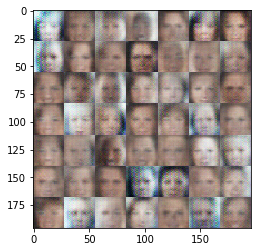

Epoch 1/1... Generator Loss: 8.0514 Discriminator Loss: 0.3447... Difference (should be positive):  -7.7066...
Epoch 1/1... Generator Loss: 2.4230 Discriminator Loss: 0.5772... Difference (should be positive):  -1.8458...
Epoch 1/1... Generator Loss: 3.2128 Discriminator Loss: 0.7409... Difference (should be positive):  -2.4718...
Epoch 1/1... Generator Loss: 3.6656 Discriminator Loss: 0.4120... Difference (should be positive):  -3.2536...
Epoch 1/1... Generator Loss: 2.4375 Discriminator Loss: 0.4595... Difference (should be positive):  -1.9780...
Epoch 1/1... Generator Loss: 0.7123 Discriminator Loss: 1.1540... Difference (should be positive):  0.4417...
Epoch 1/1... Generator Loss: 1.9314 Discriminator Loss: 0.5383... Difference (should be positive):  -1.3932...
Epoch 1/1... Generator Loss: 4.8011 Discriminator Loss: 0.3674... Difference (should be positive):  -4.4337...
Epoch 1/1... Generator Loss: 4.8383 Discriminator Loss: 0.3476... Difference (should be positive):  -4.4907...
Ep

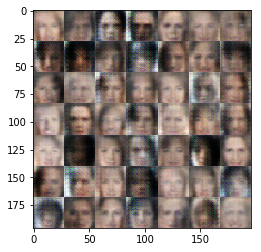

Epoch 1/1... Generator Loss: 7.0546 Discriminator Loss: 0.3502... Difference (should be positive):  -6.7044...
Epoch 1/1... Generator Loss: 6.1388 Discriminator Loss: 0.3419... Difference (should be positive):  -5.7969...
Epoch 1/1... Generator Loss: 0.8240 Discriminator Loss: 1.0257... Difference (should be positive):  0.2018...
Epoch 1/1... Generator Loss: 4.9051 Discriminator Loss: 0.3643... Difference (should be positive):  -4.5408...
Epoch 1/1... Generator Loss: 1.7637 Discriminator Loss: 0.6406... Difference (should be positive):  -1.1232...
Epoch 1/1... Generator Loss: 1.7160 Discriminator Loss: 0.6564... Difference (should be positive):  -1.0595...
Epoch 1/1... Generator Loss: 4.1139 Discriminator Loss: 0.3878... Difference (should be positive):  -3.7262...
Epoch 1/1... Generator Loss: 5.3643 Discriminator Loss: 0.3626... Difference (should be positive):  -5.0017...
Epoch 1/1... Generator Loss: 8.4781 Discriminator Loss: 0.3622... Difference (should be positive):  -8.1159...
Ep

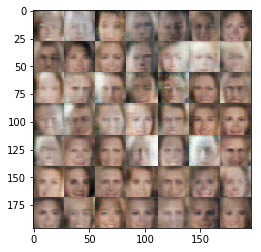

Epoch 1/1... Generator Loss: 8.1111 Discriminator Loss: 0.4175... Difference (should be positive):  -7.6936...
Epoch 1/1... Generator Loss: 5.8248 Discriminator Loss: 0.3385... Difference (should be positive):  -5.4864...
Epoch 1/1... Generator Loss: 7.4998 Discriminator Loss: 0.3911... Difference (should be positive):  -7.1087...
Epoch 1/1... Generator Loss: 5.3856 Discriminator Loss: 0.3949... Difference (should be positive):  -4.9907...
Epoch 1/1... Generator Loss: 8.4983 Discriminator Loss: 0.5720... Difference (should be positive):  -7.9262...
Epoch 1/1... Generator Loss: 8.2189 Discriminator Loss: 0.3436... Difference (should be positive):  -7.8753...
Epoch 1/1... Generator Loss: 7.6979 Discriminator Loss: 1.6708... Difference (should be positive):  -6.0271...
Epoch 1/1... Generator Loss: 3.3801 Discriminator Loss: 0.4590... Difference (should be positive):  -2.9211...
Epoch 1/1... Generator Loss: 7.3798 Discriminator Loss: 0.3470... Difference (should be positive):  -7.0328...
E

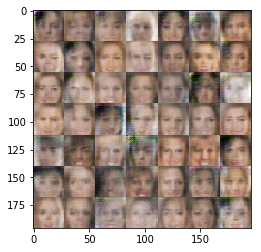

Epoch 1/1... Generator Loss: 7.5882 Discriminator Loss: 0.6830... Difference (should be positive):  -6.9052...
Epoch 1/1... Generator Loss: 4.2612 Discriminator Loss: 0.3650... Difference (should be positive):  -3.8962...
Epoch 1/1... Generator Loss: 3.2148 Discriminator Loss: 0.5676... Difference (should be positive):  -2.6472...
Epoch 1/1... Generator Loss: 9.2344 Discriminator Loss: 0.6013... Difference (should be positive):  -8.6331...
Epoch 1/1... Generator Loss: 7.6447 Discriminator Loss: 0.3470... Difference (should be positive):  -7.2977...
Epoch 1/1... Generator Loss: 8.6202 Discriminator Loss: 0.3376... Difference (should be positive):  -8.2827...
Epoch 1/1... Generator Loss: 2.3716 Discriminator Loss: 0.4940... Difference (should be positive):  -1.8776...
Epoch 1/1... Generator Loss: 2.4736 Discriminator Loss: 0.4667... Difference (should be positive):  -2.0069...
Epoch 1/1... Generator Loss: 2.8679 Discriminator Loss: 0.4240... Difference (should be positive):  -2.4439...
E

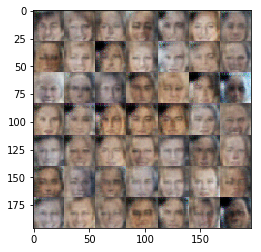

Epoch 1/1... Generator Loss: 7.5456 Discriminator Loss: 0.3440... Difference (should be positive):  -7.2016...
Epoch 1/1... Generator Loss: 3.8171 Discriminator Loss: 0.4236... Difference (should be positive):  -3.3935...
Epoch 1/1... Generator Loss: 4.0502 Discriminator Loss: 0.3762... Difference (should be positive):  -3.6739...
Epoch 1/1... Generator Loss: 4.0028 Discriminator Loss: 0.4129... Difference (should be positive):  -3.5899...
Epoch 1/1... Generator Loss: 5.9264 Discriminator Loss: 0.6850... Difference (should be positive):  -5.2415...
Epoch 1/1... Generator Loss: 0.1288 Discriminator Loss: 3.0571... Difference (should be positive):  2.9283...
Epoch 1/1... Generator Loss: 1.8751 Discriminator Loss: 0.6260... Difference (should be positive):  -1.2491...
Epoch 1/1... Generator Loss: 10.4994 Discriminator Loss: 0.3749... Difference (should be positive):  -10.1245...
Epoch 1/1... Generator Loss: 3.0248 Discriminator Loss: 0.5240... Difference (should be positive):  -2.5008...


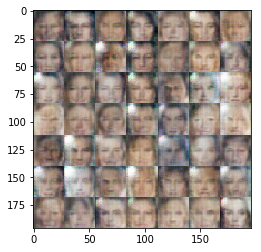

Epoch 1/1... Generator Loss: 5.2681 Discriminator Loss: 0.3877... Difference (should be positive):  -4.8803...
Epoch 1/1... Generator Loss: 1.9232 Discriminator Loss: 0.5732... Difference (should be positive):  -1.3500...
Epoch 1/1... Generator Loss: 6.8573 Discriminator Loss: 0.3499... Difference (should be positive):  -6.5073...
Epoch 1/1... Generator Loss: 5.2968 Discriminator Loss: 0.3507... Difference (should be positive):  -4.9460...
Epoch 1/1... Generator Loss: 8.1892 Discriminator Loss: 0.3411... Difference (should be positive):  -7.8480...
Epoch 1/1... Generator Loss: 2.1147 Discriminator Loss: 0.5910... Difference (should be positive):  -1.5237...
Epoch 1/1... Generator Loss: 3.8886 Discriminator Loss: 0.3969... Difference (should be positive):  -3.4917...
Epoch 1/1... Generator Loss: 2.9929 Discriminator Loss: 0.4127... Difference (should be positive):  -2.5802...
Epoch 1/1... Generator Loss: 5.6154 Discriminator Loss: 0.3576... Difference (should be positive):  -5.2578...
E

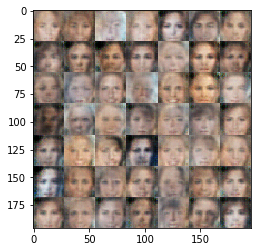

Epoch 1/1... Generator Loss: 6.3746 Discriminator Loss: 0.4356... Difference (should be positive):  -5.9390...
Epoch 1/1... Generator Loss: 3.5597 Discriminator Loss: 0.3771... Difference (should be positive):  -3.1826...
Epoch 1/1... Generator Loss: 3.9773 Discriminator Loss: 0.4097... Difference (should be positive):  -3.5676...
Epoch 1/1... Generator Loss: 3.0400 Discriminator Loss: 0.4607... Difference (should be positive):  -2.5793...
Epoch 1/1... Generator Loss: 2.8123 Discriminator Loss: 0.4762... Difference (should be positive):  -2.3361...
Epoch 1/1... Generator Loss: 2.6121 Discriminator Loss: 0.5129... Difference (should be positive):  -2.0992...
Epoch 1/1... Generator Loss: 5.9189 Discriminator Loss: 0.3426... Difference (should be positive):  -5.5763...
Epoch 1/1... Generator Loss: 7.7400 Discriminator Loss: 0.3359... Difference (should be positive):  -7.4041...
Epoch 1/1... Generator Loss: 6.9555 Discriminator Loss: 0.3399... Difference (should be positive):  -6.6156...
E

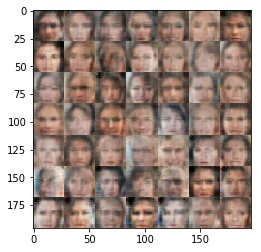

Epoch 1/1... Generator Loss: 8.2997 Discriminator Loss: 0.3457... Difference (should be positive):  -7.9540...
Epoch 1/1... Generator Loss: 4.8821 Discriminator Loss: 0.3561... Difference (should be positive):  -4.5259...
Epoch 1/1... Generator Loss: 2.2501 Discriminator Loss: 0.4931... Difference (should be positive):  -1.7569...
Epoch 1/1... Generator Loss: 4.3434 Discriminator Loss: 0.3646... Difference (should be positive):  -3.9788...
Epoch 1/1... Generator Loss: 9.2118 Discriminator Loss: 0.3338... Difference (should be positive):  -8.8780...
Epoch 1/1... Generator Loss: 6.3210 Discriminator Loss: 0.3426... Difference (should be positive):  -5.9784...
Epoch 1/1... Generator Loss: 6.8094 Discriminator Loss: 0.3385... Difference (should be positive):  -6.4709...
Epoch 1/1... Generator Loss: 5.9810 Discriminator Loss: 0.3393... Difference (should be positive):  -5.6417...
Epoch 1/1... Generator Loss: 3.9741 Discriminator Loss: 0.4556... Difference (should be positive):  -3.5185...
E

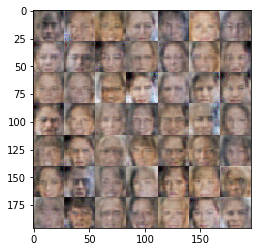

Epoch 1/1... Generator Loss: 9.4225 Discriminator Loss: 0.3549... Difference (should be positive):  -9.0676...
Epoch 1/1... Generator Loss: 2.7618 Discriminator Loss: 0.4255... Difference (should be positive):  -2.3363...
Epoch 1/1... Generator Loss: 3.9125 Discriminator Loss: 1.1331... Difference (should be positive):  -2.7794...
Epoch 1/1... Generator Loss: 0.8953 Discriminator Loss: 1.7064... Difference (should be positive):  0.8112...
Epoch 1/1... Generator Loss: 0.9102 Discriminator Loss: 1.0935... Difference (should be positive):  0.1833...
Epoch 1/1... Generator Loss: 1.8125 Discriminator Loss: 0.7235... Difference (should be positive):  -1.0890...
Epoch 1/1... Generator Loss: 2.2317 Discriminator Loss: 0.5771... Difference (should be positive):  -1.6546...
Epoch 1/1... Generator Loss: 1.2182 Discriminator Loss: 0.9265... Difference (should be positive):  -0.2917...
Epoch 1/1... Generator Loss: 3.7286 Discriminator Loss: 0.4489... Difference (should be positive):  -3.2797...
Epo

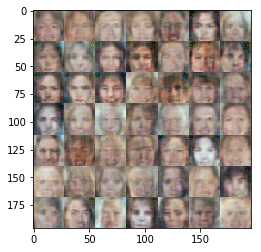

Epoch 1/1... Generator Loss: 5.7353 Discriminator Loss: 0.3737... Difference (should be positive):  -5.3617...
Epoch 1/1... Generator Loss: 6.3235 Discriminator Loss: 0.3424... Difference (should be positive):  -5.9811...


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.